In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-storm-30/validation_data.csv
/kaggle/input/data-storm-30/train_data.csv
/kaggle/input/data-storm-30/test_data.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Preprocessing of Data

#### Extracting the data into dataframes

In [3]:
# Obtaining the file paths for the input data for analysis
train_filepath = "/kaggle/input/data-storm-30/train_data.csv"
vali_filepath = "/kaggle/input/data-storm-30/validation_data.csv"
test_filepath = "/kaggle/input/data-storm-30/test_data.csv"

# Extracting the input files into dataframes
train_file = pd.read_csv(train_filepath)
vali_file = pd.read_csv(vali_filepath)
test_file  = pd.read_csv(test_filepath)

In [4]:
# display top rows of training and test data
train_file.head()

,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,11/6/2021,7
1,category_4,836584,11/18/2021,16
2,category_1,370195,1/24/2022,6
3,category_2,172582,10/30/2021,5
4,category_2,1006009,10/30/2021,5


In [5]:
vali_file.head()

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,11
1,category_2,1105009,w1,11
2,category_2,913561,w4,5
3,category_1,1048975,w4,30
4,category_1,17287,w2,60


In [6]:
# checking the number of rows with missing values in each of the dataframes

print(pd.isnull(train_file.CategoryCode).sum())
print(pd.isnull(train_file.ItemCode).sum())
print(pd.isnull(train_file.DateID).sum())
print(pd.isnull(train_file.DailySales).sum())

print(pd.isnull(vali_file.CategoryCode).sum())
print(pd.isnull(vali_file.ItemCode).sum())
print(pd.isnull(vali_file.Week).sum())
print(pd.isnull(vali_file.WeeklySales).sum())

print(pd.isnull(test_file.CategoryCode).sum())
print(pd.isnull(test_file.ItemCode).sum())
print(pd.isnull(test_file.Week).sum())

0
0
0
0
0
0
0
0
0
0
0


Therefore there are no missing data inputs we have to impute

In [7]:
# data types in train data
train_file.dtypes

CategoryCode    object
ItemCode         int64
DateID          object
DailySales       int64
dtype: object

In [8]:
# creating copies to the data files we use
train = train_file.copy()
vali = vali_file.copy()
test = test_file.copy()

### Handling of the Date Variable

Since our Test and Validation Data mainly require No of Sales value in quantity units per week, we shall convert our 'DateID' column into Week format.

We could use Month as a feature but it will be directly related to the Week number of the year. Hence using only the Week number should be sufficient.

Weeks from 39 to 52 represent data collected during the year 2021 and Weeks from 1 to 10 represent the data collected in the year 2022.

To allow continuity of the date data from 2021 to 2022, the weeks in the year 2022 (given as 1 to 10) will be adjusted to by adding 52 to each of them.

In [9]:
# converting time column into datetime object in Training Data
train['DateID'] = pd.to_datetime(train.DateID)

# creating columns for month and week
train['Week'] = train.DateID.dt.week

In [10]:
# replacing the weeks given for 2022 (which are in the range of 1 to 10) into the raange of 53 to 62
for idx in train.index:
    if train.loc[idx,'Week'] <= 10:
        train.loc[idx,'Week'] = train.loc[idx,'Week'] + 52

In [11]:
train.Week.value_counts()

52    1087
51    1072
48    1062
54    1055
49    1054
50    1053
47    1050
53    1039
45    1027
57    1020
46    1016
55    1015
56    1014
43    1011
44    1009
40     992
58     978
41     974
42     938
39     455
Name: Week, dtype: int64

We can see that incomplete week 39 (1st October - 3rd october 2021) has 455 datapoints while all the other weeks have values ranging from 900-1100.

Therefore we can choose to omit the data points for week 39 from our training, or we can adjust proportionally the datapoints for each itemcode up to 7/3 times for the whole week instead of 3 days.

##### for this method we will remove the the data points from week 39

In [12]:
train = train.loc[train.Week > 39]
train

,CategoryCode,ItemCode,DateID,DailySales,Week
0,category_2,117610,2021-11-06,7,44
1,category_4,836584,2021-11-18,16,46
2,category_1,370195,2022-01-24,6,56
3,category_2,172582,2021-10-30,5,43
4,category_2,1006009,2021-10-30,5,43
...,...,...,...,...,...
19912,category_2,75886,2021-10-04,1,40
19915,category_1,36898,2021-10-12,1,41
19916,category_2,225259,2021-10-04,4,40
19917,category_2,111436,2021-10-12,1,41


### Handling the date (Week) variable in the validation data 

In [13]:
# adding the date features into test data
vali['Week'] = vali.Week.replace("w1",59)    #  7th week of 2022
vali['Week'] = vali.Week.replace("w2",60)    #  8th week of 2022
vali['Week'] = vali.Week.replace("w3",61)    #  9th week of 2022
vali['Week'] = vali.Week.replace("w4",62)    # 10th week of 2022

In [14]:
vali

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,59,11
1,category_2,1105009,59,11
2,category_2,913561,62,5
3,category_1,1048975,62,30
4,category_1,17287,60,60
...,...,...,...,...
365,category_2,124954,60,43
366,category_2,40759,59,48
367,category_1,1090303,59,19
368,category_2,1090276,61,6


#### Handling the date (Week) variable in the test data

In [15]:
# adding the date features into test data
test['Week'] = test.Week.replace("w1",59)    #  7th week of 2022
test['Week'] = test.Week.replace("w2",60)    #  8th week of 2022
test['Week'] = test.Week.replace("w3",61)    #  9th week of 2022
test['Week'] = test.Week.replace("w4",62)    # 10th week of 2022

In [16]:
test

,CategoryCode,ItemCode,Week,PredictedSales
0,category_1,43738,62,NaN
1,category_2,1006090,59,NaN
2,category_2,1076929,62,NaN
3,category_1,1081321,61,NaN
4,category_2,216151,62,NaN
...,...,...,...,...
372,category_2,1101571,59,NaN
373,category_2,1090258,62,NaN
374,category_2,906595,59,NaN
375,category_2,32245,59,NaN


#### Creating a Dataframe for where Sales data are recorded weekly

Since our test data and validation data both use the week as the time frame, let us restructure our dataframe so that instead of units sold on a daily basis (DailySales) , we will use the units sold on a weekly basis (WeeklySales)

In [17]:
## Grouping the data rows based on both ItemCode and Week and the Category Code

train_grouped = train.groupby(['Week', 'ItemCode', 'CategoryCode']).DailySales.agg([sum])
train_grouped.sort_values(by='Week')

sum
Week ItemCode CategoryCode     
40   3418     category_1     42
     1032550  category_1     16
     1032559  category_1     17
     1032568  category_1     10
     1032586  category_1     21
...                         ...
58   211309   category_2     14
     213802   category_2      7
     216151   category_2     13
     145978   category_1     32
     1105027  category_2     14

[3593 rows x 1 columns]

In [18]:
# Resetting the index
train = train_grouped.reset_index()

# renaming the sum column into Weekly Sales

train['WeeklySales'] = train['sum']
train.drop('sum',axis=1,inplace=True)

In [19]:
train

,Week,ItemCode,CategoryCode,WeeklySales
0,40,3418,category_1,42
1,40,3427,category_1,40
2,40,7666,category_3,119
3,40,9925,category_2,9
4,40,16936,category_3,25
...,...,...,...,...
3588,58,1101769,category_2,33
3589,58,1103056,category_2,10
3590,58,1105009,category_2,11
3591,58,1105018,category_2,6


#### One hot encoding to add dummy variables for the Category Codes

In [20]:
# Using one-hot encoding to get dummy variables for the category the item belongs to
# we can drop one of the columns from these dummy varibles. We will drop the first column

categories_train = pd.get_dummies(train.CategoryCode, drop_first = True)
categories_vali = pd.get_dummies(vali.CategoryCode, drop_first = True)
categories_test = pd.get_dummies(test.CategoryCode, drop_first = True)

In [21]:
# Adding the dummy variables for Item Categories
train = pd.concat([train, categories_train], axis=1)
vali = pd.concat([vali, categories_vali], axis=1)
test = pd.concat([test, categories_test], axis=1)

In [22]:
# Removing the original column for Category Codes
train.drop('CategoryCode', axis=1, inplace = True)
vali.drop('CategoryCode', axis=1, inplace = True)
test.drop('CategoryCode', axis=1, inplace = True)

#### Correlations with Features

<AxesSubplot:>

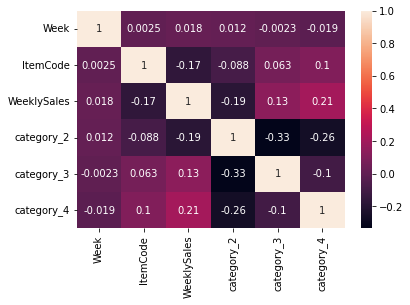

In [23]:
## correlation of all features with each other
import seaborn as sns
sns.heatmap(train.corr(), annot=True)

## Modelling the Data

#### Selecting the features and Target variables from training set and validation set

In [24]:
## Training Set split
Train_Y = train['WeeklySales']
Train_X = train[['Week','ItemCode','category_2','category_3','category_4']]

In [25]:
## Validation Set split
Vali_Y = vali['WeeklySales']
Vali_X = vali[['Week','ItemCode','category_2','category_3','category_4']]

### Decision Tree Modelling

In [26]:
## importing Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

## Importing the library to evaluate model performance - MAPE
from sklearn.metrics import mean_absolute_percentage_error

We will use an utility function to find the best Decision Tree with the most suitable number of leaf nodes which outputs the lowest error (lowest Mean Absolute Percentage Error)

In [27]:
# possible leaf node values to experiment
candidate_leaf_nodes = [25,50,75,100,125,150,175,200,225,250]

# utility function
def get_mape(leaf_nodes, Train_X, Vali_X, Train_Y, Vali_Y):
    T_Model = DecisionTreeRegressor(max_leaf_nodes = leaf_nodes, random_state=0)
    
    # applying the model and obatining our prediction
    T_Model.fit(Train_X, Train_Y)
    T_Pred_Y = T_Model.predict(Vali_X)
    
    # using mape to compare each model dependent on the leaf nodes
    mape = mean_absolute_percentage_error(Vali_Y, T_Pred_Y).round(5)
    print(leaf_nodes , mape)
    return mape

In [28]:
## a list of scores of mae and finding the lowest and mapping to the relevant leaf size
scores = {leaf_size : get_mape(leaf_size, Train_X, Vali_X, Train_Y, Vali_Y) for leaf_size in candidate_leaf_nodes}

## obtaining the best tree size for the Decision Tree using the above list
best_tree_size = min(scores, key=scores.get)
print('')
print('Best Tree Size is ' + str(best_tree_size))


25 1.17318
50 1.0291
75 0.9815
100 0.91736
125 0.89664
150 0.78089
175 0.7755
200 0.77763
225 0.77092
250 0.78203

Best Tree Size is 225


Using the results of the above analysis we can now define the Decision Tree Model for our data

In [29]:
## defining the Decision Tree Model
TreeModel = DecisionTreeRegressor(max_leaf_nodes = best_tree_size, random_state=0)

In [30]:
## fitting the data to the linear regression model
TreeModel.fit(Train_X , Train_Y)

DecisionTreeRegressor(max_leaf_nodes=225, random_state=0)

In [31]:
## Deriving the predictions for the input features of the Validation dataset
Pred_Vali = TreeModel.predict(Vali_X)

In [32]:
## Applying the MAPE to the actual target data and predicted target data
mean_absolute_percentage_error(Vali_Y, Pred_Vali)

0.7709228274556803

It achieved a better performace with the Decision Tree Model Optimizations than the linear regression (1.85969) when applied to the validation data


## Applying the Model to the Test Dataset

In [33]:
## Obtaining the test dataset for forecasting
test = test[['Week','ItemCode','category_2','category_3','category_4']]

In [34]:
## Applying the model to the test dataset and obtaining the data as integers
Pred_Test = TreeModel.predict(test).astype(int)

In [35]:
submission_file = pd.DataFrame()

In [36]:
## creating submission dataset
submission_file['ID'] = test_file['CategoryCode'].astype(str)+'_'+test_file['ItemCode'].astype(str)+'_'+test_file['Week']
submission_file['WeeklySales'] = Pred_Test

In [37]:
submission_file

,ID,WeeklySales
0,category_1_43738_w4,13
1,category_2_1006090_w1,11
2,category_2_1076929_w4,13
3,category_1_1081321_w3,13
4,category_2_216151_w4,13
...,...,...
372,category_2_1101571_w1,13
373,category_2_1090258_w4,13
374,category_2_906595_w1,11
375,category_2_32245_w1,39


In [38]:
## Obtaining the solutions as a CSV file
submission_file.to_csv('submission.csv', index=False)